# Regridding Landslide

In this example we will put both atmospheric gridded data and SHP data into the same custom grid of our choice. 

We first load useful libraries

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
from wrf import (getvar, interplevel, to_np, latlon_coords, CoordPair, xy_to_ll, ll_to_xy)
import geopandas as gp
from scipy.interpolate import griddata
import shapely
from shapely.geometry import Polygon
from shapely.geometry import Point
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
import rioxarray
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from matplotlib.patches import Circle,RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt
import warnings
warnings.filterwarnings("ignore")

We now set the number of columns displayed when inspecting a geopandas

In [4]:
pd.set_option('display.max_columns', 500)

## Regridding NetCDF

Let's start with an .nc file. In this case, we use Hail from the UNDP project. 

In [5]:
hail_file = './DATA/Wind_rt_cdf_binrange.nc'
ds        = xr.open_dataset(hail_file)

While we will have the SHP as a geopandas, using its boundaries for plotting partial results

In [10]:
df = gp.read_file('./DATA/Landslide_hazard_natanebi.shp')
df = df.to_crs(epsg=4326)
x_min, y_min, x_max, y_max = df.total_bounds

DriverError: './DATA/Landslide_hazard_natanebi.shp' not recognized as a supported file format.

The selected wind speed is the first bucket

In [9]:
intensity = 0
bin_val = ds.intensities[intensity].values
var = ds.Probability.isel(intensities=intensity)*100
print(var.min().values, var.max().values)

0.00017170067913293007 99.14692349542135


We apply the WRF package to extract the native latitudes and longitudes: 

In [6]:
lats, lons = latlon_coords(var)

This is how the wind data looks like: 

We define the new regular mesh grid based on the existing lats and lons and adding a resolution six times (or any other) the existing one. 

In [8]:
Yi = np.linspace(np.min(lats.data),float(np.max(lats.data)),6*len(lats))
Xi = np.linspace(np.min(lons.data),float(np.max(lons.data)),6*len(lons[0]))
X, Y = np.meshgrid(Xi,Yi)

We can now overlap the new gridpoints onto the previous plot to stop the black new mesh grid. 

We now regrid the .nc onto the new grid defined by X and Y

In [10]:
nvals = griddata((lons.values.ravel(),
                                   lats.values.ravel()),
                                   var.values.ravel(),
                                   (X,Y),
                                   method='linear')

The outcome is the regridded data: 

## Regridding SHP

The shapefile describes in this example a river: 

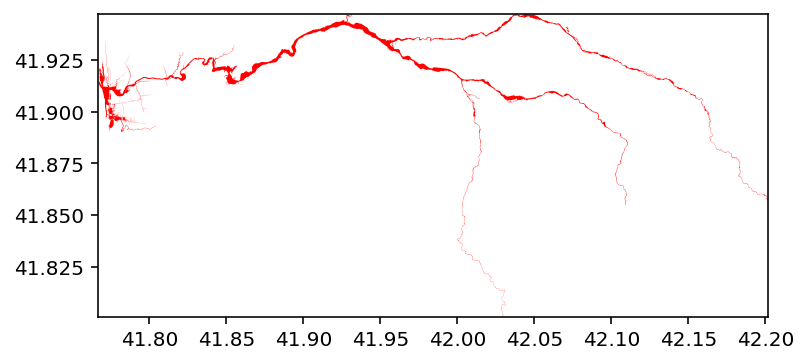

In [12]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
df.plot(ax=ax, color='red');

We now define a shapefile grid with the rectangles containing the original features, on which we will project these features. 

In [13]:
n_cells=100
cell_size = (x_max-x_min)/n_cells
grid_cells = []

for x0 in np.arange(x_min, x_max+cell_size, cell_size ):
    for y0 in np.arange(y_min, y_max+cell_size, cell_size):
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )

We now convert this shapefile into geopandas and we calculate the position of each centroid of each rectangle of the grid. 

In [14]:
cell = gp.GeoDataFrame(grid_cells, columns=['geometry'])
cell['centroids'] = cell['geometry'].centroid

The cells look like as follows 

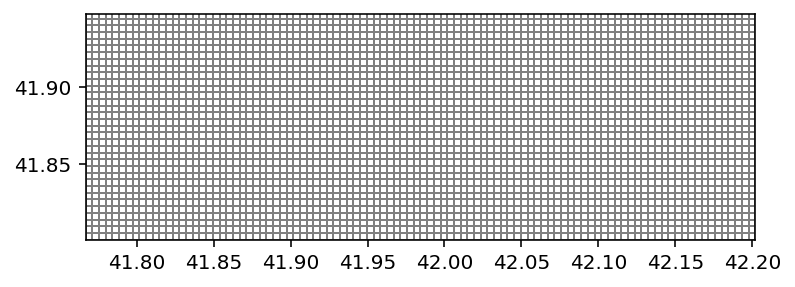

In [23]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
cell.plot(ax=ax, facecolor="none", edgecolor='grey');

The function sjoin allows us to merge the cells and the geopandas. 

In [16]:
merged = gp.sjoin(df, cell)

We now assign a value to each of the cells based on aggregation 

In [17]:
merged['aggr']=1
dissolve = merged.dissolve(by="index_right", aggfunc="count")
cell.loc[dissolve.index, 'aggr'] = dissolve.aggr.values

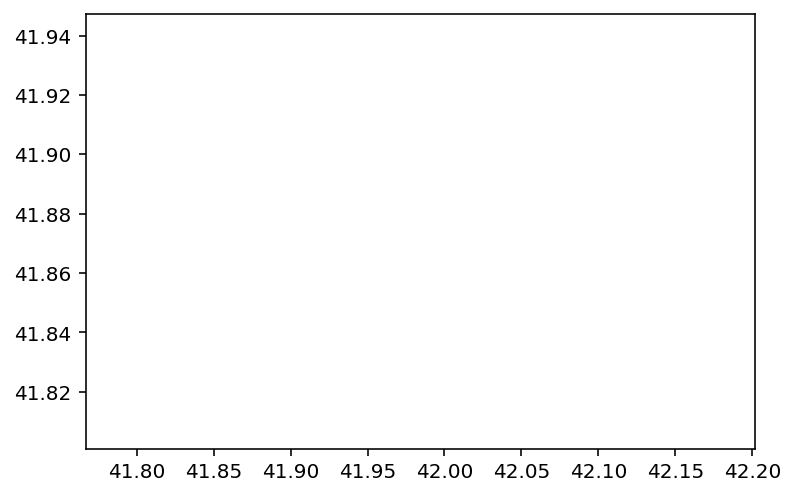

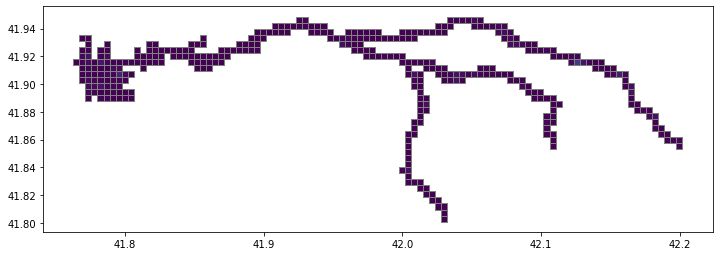

In [26]:
fig,ax2 = plt.subplots(dpi=144)
ax2.set_ylim(y_min,y_max)
ax2.set_xlim(x_min,x_max)
ax2 = cell.plot(column='aggr', figsize=(12, 8), cmap='viridis', vmax=100, edgecolor="grey");

Finally, we regrid the centroid-based grid into the grid we have defined before. 

In [19]:
x = cell['centroids'].x
y = cell['centroids'].y
z = cell['aggr']

points = (x,y)
values = z

river = griddata(points,
                    values,
                    (X,Y),
                    method='nearest')

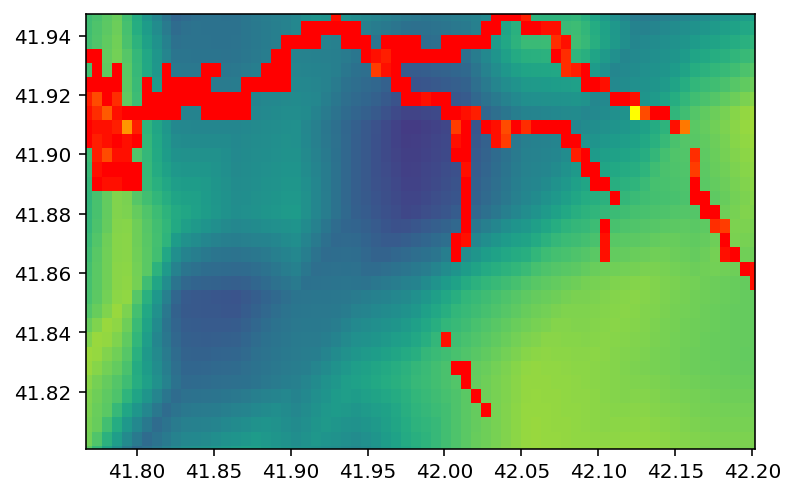

In [27]:
fig,ax = plt.subplots(dpi=144)
ax.set_ylim(y_min,y_max)
ax.set_xlim(x_min,x_max)
ax.pcolormesh(X,Y,nvals)
ax.pcolormesh(X,Y,river,cmap='autumn');